In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import pickle #To use cifar-10

%matplotlib inline

In [2]:
#Load trainset_CIFAR_10
#https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle_trainset_CIFAR_10(file):
    dicts = dict()
    for i in range(1, 6):   #This dataset is divided into 5 files.
        if i == 1:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = file_dict[b'data']
            dicts[b'labels'] = file_dict[b'labels']
        else:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = np.concatenate((dicts[b'data'], file_dict[b'data']))
            dicts[b'labels'] += file_dict[b'labels']
    return dicts

#Load testset_CIFAR_10
def unpickle_testset_CIFAR_10(file):
    dicts = pickle.load(open(file, 'rb'), encoding = 'bytes')
    return dicts

#Load MNIST
#http://yann.lecun.com/exdb/mnist/
def unpickle_MNIST(image, label):
    #Read Image data
    image_set = open(image, 'rb')
    magic_number = struct.unpack(">i", image_set.read(4))[0]
    number_images = struct.unpack(">i", image_set.read(4))[0]
    rows = struct.unpack(">i", image_set.read(4))[0]
    cols = struct.unpack(">i", image_set.read(4))[0]
    image_set_data = np.reshape(np.fromstring(image_set.read(), dtype = np.uint8), (number_images, rows * cols))
    image_set.close()
    #Read Label data
    label_set = open(label, 'rb')
    magic_number = struct.unpack(">i", label_set.read(4))[0]
    number_of_items = struct.unpack(">i", label_set.read(4))[0]
    label_set_data = np.reshape(np.fromstring(label_set.read(), dtype = np.uint8), (number_of_items))
    label_set.close()    
    return image_set_data, label_set_data

In [3]:
def shuffle(X, y):
    """
    Argument:
    X -- all training_data
    y -- all training_label
    
    Return:
    X_train -- training_dataset
    y_train -- training_labelset
    X_cross -- cross_validation_dataset
    y_cross -- cross_validation_labelset
    """

    data_count = X.shape[0]
    shuffle_order = np.arange(data_count)
    np.random.shuffle(shuffle_order)
    X_train, y_train = X[shuffle_order][:(4 * data_count) // 5], y[shuffle_order][:(4 * data_count) // 5]
    X_cross, y_cross = X[shuffle_order][(4 * data_count) // 5:], y[shuffle_order][(4 * data_count) // 5:]
    return X_train, y_train, X_cross, y_cross

In [4]:
class Softmax_classifier():
    def __init__(self):
        pass
    
    def train(self, X_train, y_train, learning_rate = 0.1, iterations = 5000, check = False):
        """
        Argument:
        X_train -- training_data
        y_train -- training_label
        learning_rate -- learning_rate(alpha) of gradient descent. default value is 0.1
        iterations -- number of iterations of the optimization loop. default value is 5000
        check -- if check is True, check the analytic gradient through a numerical gradient. default value is False

        Store:
        W -- weights matrix
        b -- bias vector(1-dimension matrix)
        errorindex, error -- save value of iterations(index), save value of loss functions.         
        """
        self.X_train = X_train / 255 # To prevent overflow
        self.y_train = y_train
        pixelcount = self.X_train.shape[1]
        kindofclass = 10
        # initialize, (Xavier initialize)
        self.W = np.random.randn(pixelcount, kindofclass).astype(np.float64) * np.sqrt(2 / self.X_train.shape[0])
        self.b = np.zeros(kindofclass).astype(np.float64)
        self.errorindex = []
        self.error = []
        for i in range(1, iterations + 1):
            # getting matrix which applied softmax classifier.
            softmax_matrix = self.softmaxcal(self.W, self.b)
            error = self.calculate_error(softmax_matrix)
            self.errorindex.append(i)
            self.error.append(error)
            dW, db = self.gradient(softmax_matrix)
            if check == True:
                print("gradient", dW[:3, :3], db[:3])
                self.gradient_check()
                if i > 3:
                    check = False
            # update W, b
            self.W -= learning_rate / i * dW
            self.b -= learning_rate / i * db
            if i % 500 == 0:
                print(i, "iterations finished")
    
    def softmaxcal(self, W, b):
        """
        Argument:
        X_train -- training_data
        y_train -- training_label
        W -- weights matrix
        b -- bias vector(1-dimension matrix)
        
        Return:
        softmax -- matrix which applied softmax classifier.
        """
        softmax = np.exp(np.matmul(self.X_train, W) + b)
        softmax /= softmax.sum(keepdims = True, axis = 1)
        return softmax
    
    def calculate_error(self, matrix):
        """
        Argument:
        matrix -- matrix which applied softmax classifier
        
        Return:
        error -- value of cross-entropy-loss.
        """
        error = np.sum(-np.log(matrix[np.arange(matrix.shape[0]), self.y_train])) / matrix.shape[0]
        return error
    
    def gradient(self, matrix):
        """
        Argument:
        matrix -- matrix which applied softmax classifier.
        
        Return:
        dW -- gradient matrix about W.
        db -- gradient matrix about b.
        """
        # if suppose f is softmax classifier, b = f(a), L = -sum(yk*log(bk))
        # Then, dL/dai = -sum(yk/bk * dbk/dai), if i == k, 1/bk * dbk/dai = yk(1 - bk), i != k, 1/bk * dbk/dai = -yk*bk
        # So, dL/dai = bi - yi (because sum(yk) == 1)
        matrix[np.arange(matrix.shape[0]), self.y_train] -= 1
        # backpropagation
        dW = np.matmul(self.X_train.T, matrix) / self.X_train.shape[0]
        db = np.sum(matrix, axis = 0) / self.X_train.shape[0]
        return dW, db
    
    def gradient_check(self, h = 0.00001):
        """
        Argument:
        h -- very small positive number, default value is 0.00001.
        """
        # Use dy/dx = lim(x->0)(f(x + h) - f(x - h) / (2 * h))        
        # numerical gradient_check
        dW = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)
        for i in range(3):
            for j in range(3):
                self.W[i][j] += h
                svm_matrix1 = self.softmaxcal(self.W, self.b)
                loss1 = self.calculate_error(svm_matrix1)
                self.W[i][j] -= 2 * h
                svm_matrix2 = self.softmaxcal(self.W, self.b)
                loss2 = self.calculate_error(svm_matrix2)
                dW[i][j] = (loss1 - loss2) / (2 * h)
                self.W[i][j] += h
        for i in range(3):
            self.b[i] += h
            svm_matrix1 = self.softmaxcal(self.W, self.b)
            loss1 = self.calculate_error(svm_matrix1)
            self.b[i] -= 2 * h
            svm_matrix2 = self.softmaxcal(self.W, self.b)
            loss2 = self.calculate_error(svm_matrix2)
            db[i] = (loss1 - loss2) / (2 * h)
            self.b[i] += h
        print("numerical", dW[:3, :3], db[:3])
    
    def predict(self, X_test):
        """
        Argument:
        X_test -- test_data
        
        Return:
        constant_value -- predicted label number
        """
        softmax = np.matmul(X_test / 255, self.W) + self.b
        return softmax.argmax(axis = 1)
    
    def accuracy(self, X_test, y_test):
        """
        Argument:
        X_test -- test_data
        y_test -- test_label
        
        Return:
        value -- accuracy of classifier
        """
        return np.mean(self.predict(X_test) == y_test) * 100

In [6]:
# MNIST
train_image_name = "mnist\\train-images.idx3-ubyte"
train_label_name = "mnist\\train-labels.idx1-ubyte"
test_image_name = "mnist\\t10k-images.idx3-ubyte"
test_label_name = "mnist\\t10k-labels.idx1-ubyte"

X, y = unpickle_MNIST(train_image_name, train_label_name)
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = unpickle_MNIST(test_image_name, test_label_name)

Softmax_mnist = Softmax_classifier()
Softmax_mnist.train(X_train[:3000], y_train[:3000], iterations = 5000, check = True)

gradient [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [-0.00137463  0.02249318 -0.00898613]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [-0.00137463  0.02249318 -0.00898613]
gradient [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.00761507 -0.00222943 -0.00390356]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.00761507 -0.00222943 -0.00390356]
gradient [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.00999026 -0.00786494 -0.00248962]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.00999026 -0.00786494 -0.00248962]
gradient [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.01119497 -0.01067053 -0.00174371]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.01119497 -0.01067053 -0.00174371]


KeyboardInterrupt: 

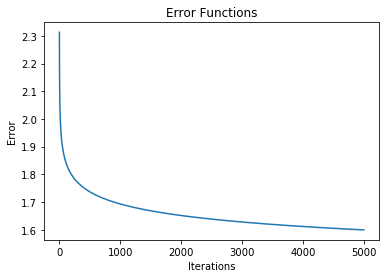

In [60]:
#Visualizing Error Curve
plt.plot(Softmax_mnist.errorindex, Softmax_mnist.error)
plt.title("Error Functions")
plt.xlabel('Iterations')
plt.ylabel('Error')

In [62]:
print("Test set accuracy is ", Softmax_mnist.accuracy(X_test, y_test))
print("Train set accuracy is ", Softmax_mnist.accuracy(X_train[:3000], y_train[:3000]))

Test set accuracy is  74.19
Train set accuracy is  74.1666666667


Number of this picture is 1
Prediction =  1


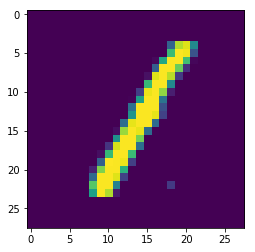

In [82]:
def onesample(self, X_test):
    softmax = np.matmul(X_test / 255, self.W) + self.b
    index = softmax.argmax()
    return index


#Visualizing MNIST
X = X_train.reshape(48000, 28, 28)
i = np.random.choice(range(len(X)))
plt.imshow(X[i], interpolation = 'nearest')
print("Number of this picture is", y_train[i])
print("Prediction = ", onesample(Softmax_mnist, X_train[i]))

In [5]:
file_name = 'cifar-10\data_batch_'
datadict = unpickle_trainset__CIFAR_10(file_name)
file_name = 'cifar-10\\test_batch'
testdict = unpickle_testset__CIFAR_10(file_name)
classlist = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X, y = datadict[b'data'], np.array(datadict[b'labels'])
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = testdict[b'data'], np.array(testdict[b'labels'])
print(X_train.shape)

a = Softmax_classifier()
a.train(X_train, y_train, iterations = 100, check = True)

(40000, 3072)


KeyboardInterrupt: 

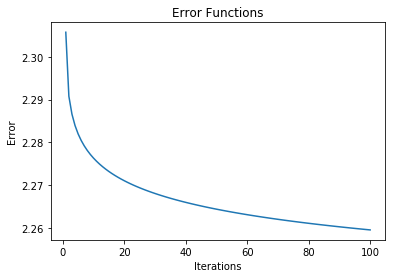

In [15]:
plt.plot(a.errorindex, a.error)

plt.title("Error Functions")
plt.xlabel('Iterations')
plt.ylabel('Error')


In [17]:
print(a.accuracy(X_test, y_test))
print(a.accuracy(X_train / 255, y_train))

17.25
16.7975


class is bird 2


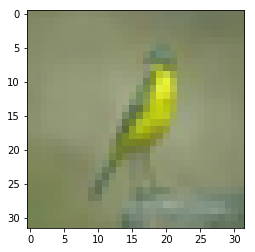

In [19]:
X = X_train.reshape(40000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
Y = np.array(y_train)

#Visualizing CIFAR 10
i = np.random.choice(range(len(X)))
k = np.random.choice(range(1, 100))
plt.imshow(X[i], interpolation='nearest')
print("class is", classlist[Y[i]], Y[i])